In [1]:
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

# Preprocessing a Whole Slide Image

In this section, we will walk you through a general workflow on how to process WSI using LazySlide.

## `wsiata`
In LazySlide, we mainly work with `WSIData`, which extends upon `SpatialData` with a WSI reader.

You can use `WSIData` directly as `SpatialData` in other scverse packages.

If you want to know more, please refer to [WSIData](https://wsidata.readthedocs.io/en/latest/intro/index.html).

## import

The convention namespace for lazyslide is always `zs`.

In [2]:
from wsidata import open_wsi
import lazyslide as zs

/Users/eabila/workspace/clones/LazySlide/.venv/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/eabila/workspace/clones/LazySlide/.venv/lib/python3.12/site-packages/timm/models/hub.py:4: FutureWarning: Importing from timm.models.hub is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


## Open a WSI

Here we use an Esophagus slide from GTEx as example.

https://brd.nci.nih.gov/brd/imagedownload/GTEX-11ZUS-2026

When you open an WSI, you will get a `WSIData`. The `WSIData` is usually stored side by side with your WSI file. If you want to attach antoher `WSIData`, you can specify one.

In [5]:
wsi = open_wsi("GTEX-11ZUS-2026.svs")
# wsi = open_wsi("GTEX-11ZUS-2026.svs", store="my_wsidata.zarr")

## What's in the wsi?

In [6]:
wsi

WSI: GTEX-11ZUS-2026.svs
Reader: openslide
SpatialData object
└── Images
      └── 'wsi_thumbnail': DataArray[cyx] (3, 1464, 1711)
with coordinate systems:
    ▸ 'global', with elements:
        wsi_thumbnail (Images)

Let's check the slide metadata, this is a slide scan at 20X (magnification) with a mpp (micro per pixel) of 0.4942, it's shape is 40553 * 47807

In [7]:
wsi.properties

Field,Value
shape,"[42615, 49799]"
n_level,3
level_shape,"[[42615, 49799], [10653, 12449], [2663, 3112]]"
level_downsample,"[1.0, 4.000261297012679, 16.0024389858356]"
mpp,0.4942
magnification,20.0
bounds,"[0, 0, 49799, 42615]"


We can first take a quick look at slide, what does it look like.

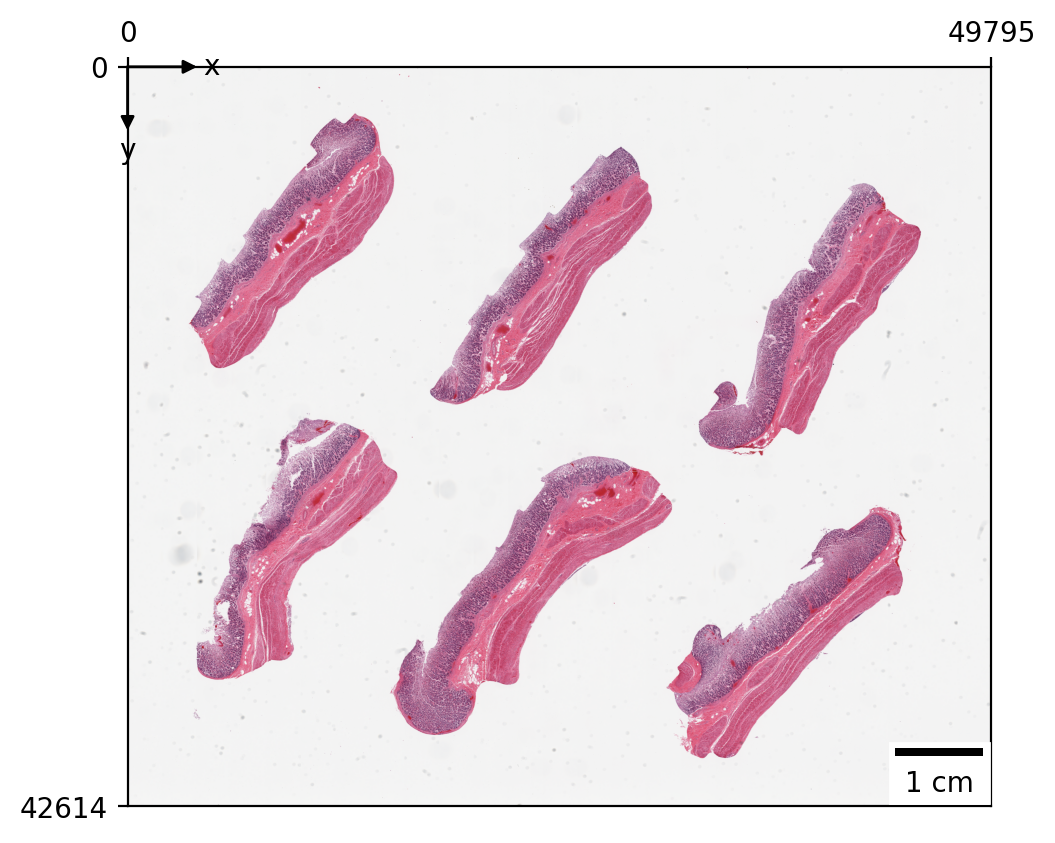

In [8]:
zs.pl.tissue(wsi)

## Tissue Segmentation

Before we proceed to other analysis, we need to segment the tissue from the slide.

We can take a quick look of the segmentation result, the <span style="color: green;">greens</span> are the tissue borders, the <span style="color: blue;">blues</span> are the holes that will be excluded.

The default parameters ususally works pretty well, but you may go ahead to adjust some parameters to fit your need.

In [9]:
zs.pp.find_tissues(wsi)
wsi

WSI: GTEX-11ZUS-2026.svs
Reader: openslide
SpatialData object
├── Images
│     └── 'wsi_thumbnail': DataArray[cyx] (3, 1464, 1711)
└── Shapes
      └── 'tissues': GeoDataFrame shape: (6, 2) (2D shapes)
with coordinate systems:
    ▸ 'global', with elements:
        wsi_thumbnail (Images), tissues (Shapes)

As you may notice, a new `GeoDataFrame` named `tissues` is added to `WSIData`. 

A tissue table will always contains a `tissue_id` column so you can identify the exact tissue piece.

In [10]:
wsi["tissues"]

,tissue_id,geometry
0,0,"POLYGON ((43174.82 25273.651, 43170.82 25277.6..."
1,1,"POLYGON ((26997.763 22453.467, 26993.763 22457..."
2,2,"POLYGON ((10232.668 20253.323, 10228.668 20257..."
3,3,"POLYGON ((42354.767 6748.441, 42350.766 6752.4..."
4,4,"POLYGON ((28397.855 4652.304, 28393.855 4656.3..."
5,5,"POLYGON ((13120.857 2712.177, 13120.857 2716.1..."


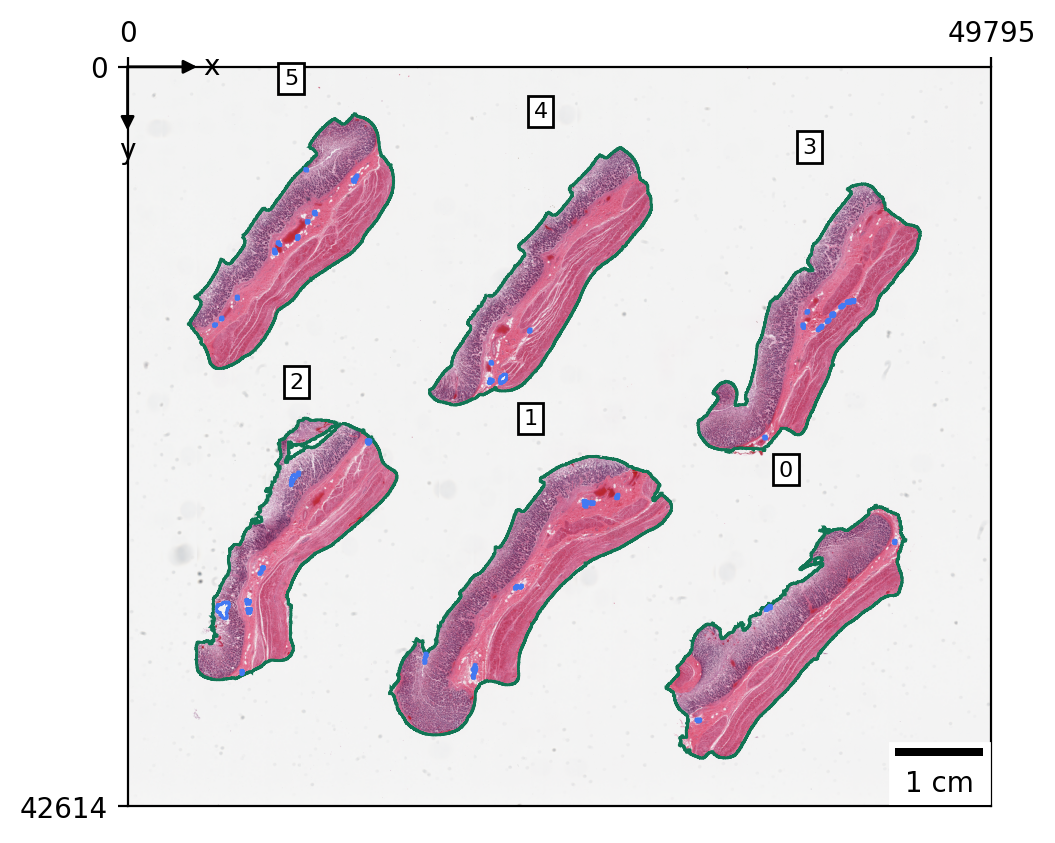

In [11]:
zs.pl.tissue(wsi)

We can also take a detail look on a specific tissue instance.

In [ ]:
zs.pl.tissue(wsi, tissue_id=5)

## Tissue QC

In [17]:
zs.pp.score_tissues(wsi, scores=["brightness", "redness"])

## Tissue properties

You can quickly get the geometry properties of each tissue instances.

In [13]:
zs.tl.tissue_props(wsi)

In [14]:
wsi["tissues"]

,tissue_id,geometry,area,area_filled,convex_area,solidity,convexity,axis_major_length,axis_minor_length,eccentricity,...,moment-mu21,moment-mu12,moment-mu03,moment-nu20,moment-nu11,moment-nu02,moment-nu30,moment-nu21,moment-nu12,moment-nu03
0,0,"POLYGON ((43174.82 25273.651, 43170.82 25277.6...",76423522.0,76543706.0,99213302.0,0.770295,1.298204,19563.804688,5797.953125,0.955076,...,-5.976270e+17,4.763970e+17,-1.945574e+17,0.173116,-0.142521,0.163500,0.008517,-0.011659,0.009294,-0.003796
1,1,"POLYGON ((26997.763 22453.467, 26993.763 22457...",92806314.0,93177002.0,117016404.5,0.793105,1.260867,23237.796875,6202.780273,0.963717,...,2.124343e+17,-8.892601e+17,1.354885e+18,0.164700,-0.159029,0.203406,0.007435,0.002535,-0.010611,0.016167
2,2,"POLYGON ((10232.668 20253.323, 10228.668 20257...",73482374.0,74331838.0,94801354.5,0.775119,1.290124,17655.039062,6250.948730,0.935223,...,8.658694e+16,-5.626643e+17,1.050854e+18,0.094408,-0.111805,0.223016,0.005091,0.001818,-0.011812,0.022060
3,3,"POLYGON ((42354.767 6748.441, 42350.766 6752.4...",75111542.0,75439046.0,89583812.0,0.838450,1.192677,19904.220703,5479.055664,0.961367,...,3.361880e+17,-3.544121e+17,1.914417e+17,0.109213,-0.127550,0.217908,-0.004937,0.006801,-0.007170,0.003873
4,4,"POLYGON ((28397.855 4652.304, 28393.855 4656.3...",69501078.0,69751574.0,77335210.0,0.898699,1.112720,19725.101562,4885.314941,0.968844,...,1.043308e+17,-3.624049e+16,-8.786689e+16,0.129622,-0.142379,0.209526,-0.002769,0.002568,-0.000892,-0.002162
5,5,"POLYGON ((13120.857 2712.177, 13120.857 2716.1...",72092274.0,72397354.0,81169692.0,0.888167,1.125914,18315.830078,5555.069336,0.952897,...,3.147706e+17,-3.314732e+17,1.493190e+17,0.119666,-0.116821,0.173227,-0.003769,0.007058,-0.007433,0.003348


## Tiling

The slide images are usually too large to fit into memory, a widly adopted strategy is to create smaller tiles or patches.

```{note}
If you are working with many slides from different sources. Harmonization is very important to account for batch effects. In tiling steps, if your slides have different magnification, you should specify a mpp value that the tiling should works on.
```

Here is a list of mpp value map with magnification:
<table>
    <thead>
        <tr>
            <th>Magnification</th>
            <th>MPP (Microns per Pixel)</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>40×</td>
            <td>0.25</td>
        </tr>
        <tr>
            <td>20×</td>
            <td>0.5</td>
        </tr>
        <tr>
            <td>10×</td>
            <td>1</td>
        </tr>
    </tbody>
</table>

In [23]:
zs.pp.tile_tissues(wsi, 1024, mpp=0.5)
wsi

/Users/eabila/workspace/clones/LazySlide/.venv/lib/python3.12/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `tiles` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


WSI: GTEX-11ZUS-2026.svs
Reader: openslide
SpatialData object
├── Images
│     └── 'wsi_thumbnail': DataArray[cyx] (3, 1464, 1711)
├── Shapes
│     ├── 'tiles': GeoDataFrame shape: (385, 5) (2D shapes)
│     └── 'tissues': GeoDataFrame shape: (6, 51) (2D shapes)
└── Tables
      └── 'resnet50_tiles': AnnData (6655, 2048)
with coordinate systems:
    ▸ 'global', with elements:
        wsi_thumbnail (Images), tiles (Shapes), tissues (Shapes)

Now, a new GeoDataFrame `tiles` is added to `WSIData` and is mapped to `tissue_id`.

In [24]:
wsi["tiles"]

,id,x,y,tissue_id,geometry
0,0,32074,33561,0,"POLYGON ((33110 33561, 33110 34597, 32074 3459..."
1,1,32074,34597,0,"POLYGON ((33110 34597, 33110 35633, 32074 3563..."
2,2,32074,35633,0,"POLYGON ((33110 35633, 33110 36669, 32074 3666..."
3,3,32074,36669,0,"POLYGON ((33110 36669, 33110 37705, 32074 3770..."
4,4,32074,37705,0,"POLYGON ((33110 37705, 33110 38741, 32074 3874..."
...,...,...,...,...,...
380,380,12824,8928,5,"POLYGON ((13860 8928, 13860 9964, 12824 9964, ..."
381,381,13860,4784,5,"POLYGON ((14896 4784, 14896 5820, 13860 5820, ..."
382,382,13860,5820,5,"POLYGON ((14896 5820, 14896 6856, 13860 6856, ..."
383,383,13860,6856,5,"POLYGON ((14896 6856, 14896 7892, 13860 7892, ..."


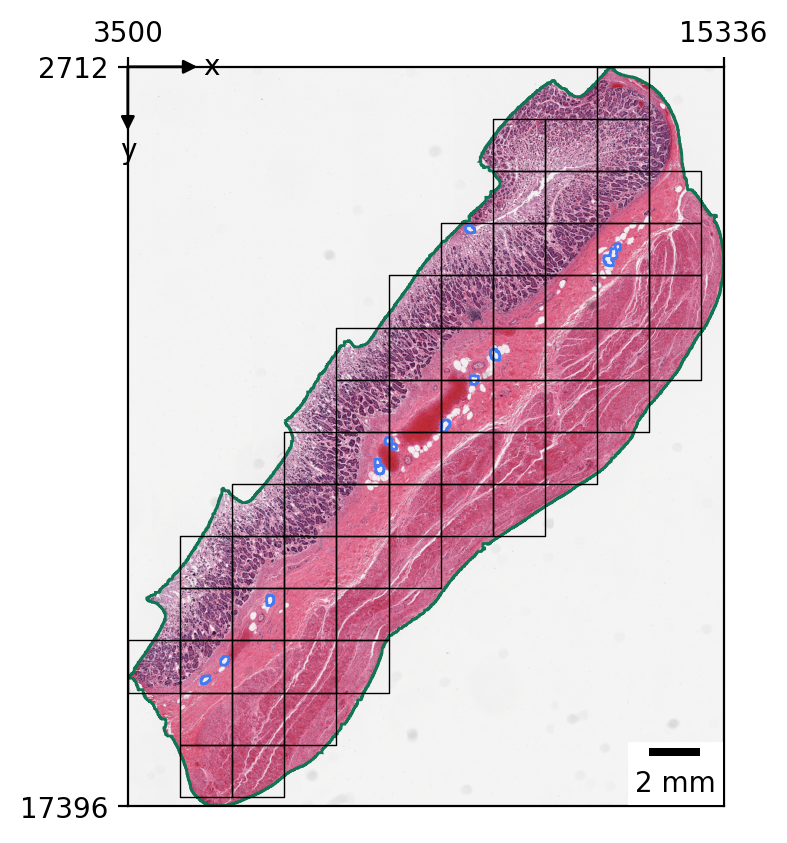

In [26]:
zs.pl.tiles(wsi, tissue_id=5, linewidth=0.5)

In [28]:
zs.pp.score_tiles(wsi, scorers=["contrast", "focus"], num_workers=4)

Output()

/Users/eabila/workspace/clones/LazySlide/.venv/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/eabila/workspace/clones/LazySlide/.venv/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/eabila/workspace/clones/LazySlide/.venv/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configur

In [29]:
wsi["tiles"]

,id,x,y,tissue_id,geometry,contrast,focus
0,0,32074,33561,0,"POLYGON ((33110 33561, 33110 34597, 32074 3459...",0.866667,0
1,1,32074,34597,0,"POLYGON ((33110 34597, 33110 35633, 32074 3563...",0.811765,0
2,2,32074,35633,0,"POLYGON ((33110 35633, 33110 36669, 32074 3666...",0.866667,0
3,3,32074,36669,0,"POLYGON ((33110 36669, 33110 37705, 32074 3770...",0.870588,0
4,4,32074,37705,0,"POLYGON ((33110 37705, 33110 38741, 32074 3874...",0.631373,0
...,...,...,...,...,...,...,...
380,380,12824,8928,5,"POLYGON ((13860 8928, 13860 9964, 12824 9964, ...",0.800000,0
381,381,13860,4784,5,"POLYGON ((14896 4784, 14896 5820, 13860 5820, ...",0.788235,0
382,382,13860,5820,5,"POLYGON ((14896 5820, 14896 6856, 13860 6856, ...",0.811765,0
383,383,13860,6856,5,"POLYGON ((14896 6856, 14896 7892, 13860 7892, ...",0.800000,0


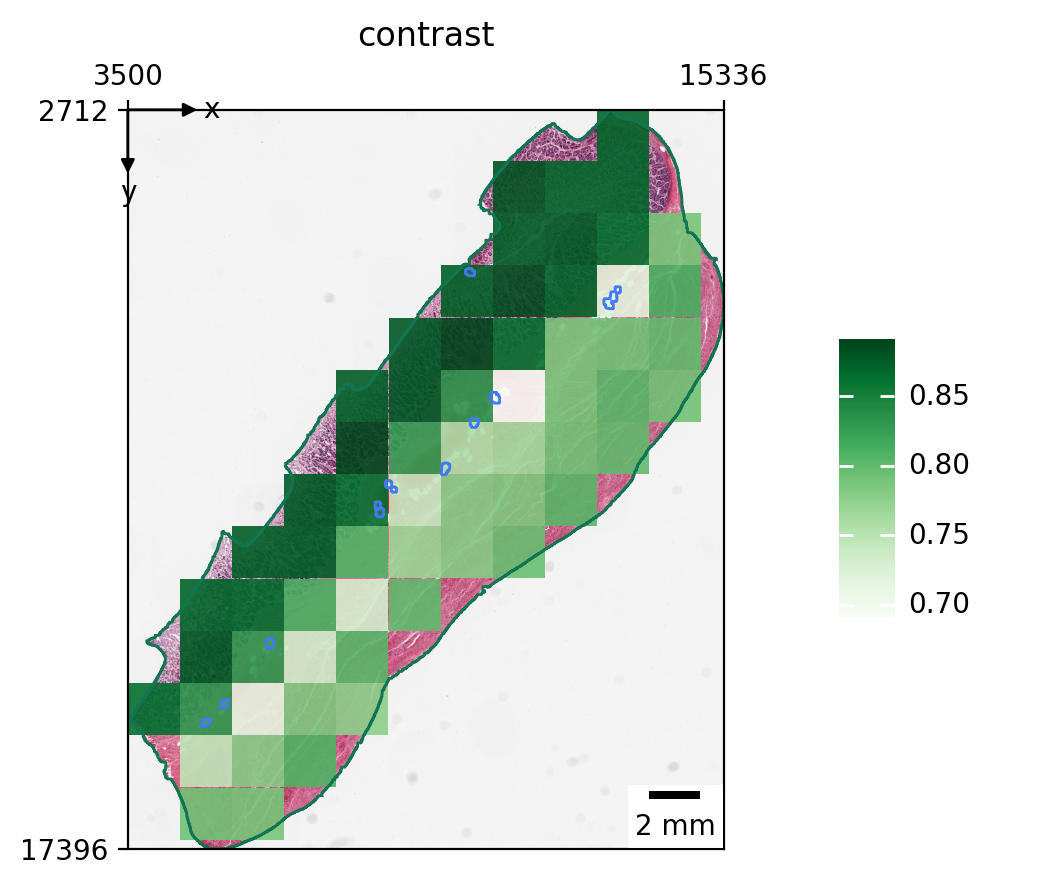

In [34]:
zs.pl.tiles(wsi, tissue_id=5, color="contrast", cmap="Greens")

## Feature extraction

Feature extraction is to transform the image into a the numeric representation, which comprises of different morphological features. 

Typically, this is done by feeding the tiles into a vision model.

In [35]:
zs.tl.feature_extraction(wsi, "resnet50", device="mps")

Output()

/Users/eabila/workspace/clones/LazySlide/.venv/lib/python3.12/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `resnet50_tiles` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


You can easily use foundational models in LazySlide by specifying the name:

Currently supported: 'uni', 'uni2', 'conch', 'conch_vision', 'gigapath'

:::{note}
For foundation models, please request access at the corresponding huggingface repository.

In [36]:
zs.tl.feature_extraction(wsi, "uni", device="mps")

Output()

In [38]:
wsi

WSI: GTEX-11ZUS-2026.svs
Reader: openslide
SpatialData object
├── Images
│     └── 'wsi_thumbnail': DataArray[cyx] (3, 1464, 1711)
├── Shapes
│     ├── 'tiles': GeoDataFrame shape: (385, 7) (2D shapes)
│     └── 'tissues': GeoDataFrame shape: (6, 51) (2D shapes)
└── Tables
      ├── 'resnet50_tiles': AnnData (385, 2048)
      └── 'uni_tiles': AnnData (385, 1024)
with coordinate systems:
    ▸ 'global', with elements:
        wsi_thumbnail (Images), tiles (Shapes), tissues (Shapes)

Features are saved as `AnnData` store with a convention of "{model name}_{tiles key}".

### Feature aggregation

To perform analysis across dataset, a usual way is to pool features into a 1D vector that can represent the entire slide.

Features can be aggregated at different levels, such as slide-level and tissue-level. 

In [39]:
zs.tl.feature_aggregation(wsi, "resnet50", by="slide")
zs.tl.feature_aggregation(wsi, "resnet50", by="tissue_id")

In [40]:
wsi["resnet50_tiles"]

AnnData object with n_obs × n_vars = 385 × 2048
    obs: 'tile_id', 'library_id', 'tissue_id'
    uns: 'spatialdata_attrs', 'agg_ops'
    varm: 'agg_slide', 'agg_tissue_id'

In [41]:
wsi.fetch.features_anndata("resnet50")

AnnData object with n_obs × n_vars = 385 × 2048
    obs: 'id', 'x', 'y', 'tissue_id', 'contrast', 'focus'
    uns: 'tile_spec', 'slide_properties'
    obsm: 'spatial'
    varm: 'agg_slide', 'agg_tissue_id'

## Save on the disk

The WSIData is saved side by side with your WSI file by default. When you open the WSI next time, it will automatically pick up the WSIData.

In [42]:
wsi.write()

INFO     The Zarr backing store has been changed from None the new file path: GTEX-11ZUS-2026.zarr                 


Notice that after saving, your `SpatialData` is now associated with a disk storage.

In [43]:
wsi

WSI: GTEX-11ZUS-2026.svs
Reader: openslide
SpatialData object, with associated Zarr store: /Users/eabila/workspace/clones/LazySlide/docs/source/tutorial/GTEX-11ZUS-2026.zarr
├── Images
│     └── 'wsi_thumbnail': DataArray[cyx] (3, 1464, 1711)
├── Shapes
│     ├── 'tiles': GeoDataFrame shape: (385, 7) (2D shapes)
│     └── 'tissues': GeoDataFrame shape: (6, 51) (2D shapes)
└── Tables
      ├── 'resnet50_tiles': AnnData (385, 2048)
      └── 'uni_tiles': AnnData (385, 1024)
with coordinate systems:
    ▸ 'global', with elements:
        wsi_thumbnail (Images), tiles (Shapes), tissues (Shapes)